<img style="float: right;" src="thk.jpg" width="150" >

# Lab Digital Communication: Baseband transmission over the AWGN channel



Your Name: Alexander Müller                                           Matrikulation number:  11118968


Name of the partner: Steffen Klein                                    Matrikulation number: 11117177

During this lab you shall build up a simple binary transmission link and simulate the bit error probability for the AWGN channel. You will have to present your results to your supervisor and explain your code. The final exam will contain questions related to the lab. Therefore, do it yourself and make a serious effort.

The considered link shall consist of the following building blocks:

1. a random generator that generates a binary sequence of length $N$
2. a mapper that maps the bits to symbols. Unipolar and antipodal transmission should be possible and can be chosen by the user
3. an upsampler with appropriate sampling factor
4. a transmit filter which has either a rectangular pulse shape or a RRC pulse shape with roll-off factor $\alpha$
5. a block that adds AWGN with a given signal to noise ratio
6. a matched filter receiver with down sampler
7. a decision device to estimate the transmitted bits
8. an evaluation unit that measures the bit error rate

Additionally, the following plots shall be generated:
* a detail plot of the time domain signal in front of the channel block
* a detail plot of the time domain signal after the matched filter and in front of downsamling and decision device
* an eye diagram after the matched filter and before downsampling
* a scatter diagramm in front of the decision block in the receiver
* a plot of the $BER$ vs. the $Eb/N_0$

**Hint:** Use numpy functions for the numerical calculations and pyplot for the plots. Scipy provides filtering functions.

# Your program

Insert your code at the specified positions in the following cells. Test each cell before proceeding.

## Useful libraries

In [13]:
# figures inline
%matplotlib inline              
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sp                   # Signal processing

# The random generator
The random genrator shall generate a binary sequence of length N

In [28]:
# The binary random sequence generator
N = int(input('Please choose an appropriate sequence length N: '))
print('Sequence length N= ',N)
# insert your code from here (this example is provided by your supervisor)
bin_seq = np.random.randint(2, size=N)
print('binary sequence = ',bin_seq)
t = np.arange(0, N)

Please choose an appropriate sequence length N: 10000
Sequence length N=  10000
binary sequence =  [1 0 0 ... 0 1 0]


What is influenced by the choice of $N$? Answer below!


**Answer:** *The BER that can be measured and its accuracy depends on N. On the other hand the processing time increases with N, too.*

# The modulator
The modulator shall  map the bits to symbols and generate the digital waveforms that build the transmit signal. The user can chose between a unipolar or a bipolar transmission. Please normalize the power to one.

What steps have to be taken in the modulator? Answer below:

**My answer:**
1. Decide wheter unipolar or bipolar modulation shall be used
2. Perform upsampling of the incoming data bits (simply add n zeros behind each data bit)
3. Apply pulse-shaping filter onto bit-stream to create transmission pulses

According to the desired modulation scheme (unipolar or bipolar) the incoming bits have to be mapped to the transmission pulse. In the case of unipolar modulation, e.g. a binary '1' gets mapped to p(t), while a binary '0' gets mapped to  0. For bipolar modulation the association would be '1' to p(t) and '0' to -p(t). At this point is does not matter, what kind of pulse is used for transmission (e.g. rect, RRC, ...). Also the mapping from of the bits to the pulses is arbritrary. The performance of the modulator would stay the same if for example in the bipolar case '1' would be mapped to -p(t) and '0' to p(t). However for modulation schemes, which map multiple bits onto a symbol a optimized mapping (as given by Gray coding) can be used to reduce the average bit error at a constant symbol error.

In [29]:
# The modulator
mod_type= int(input('unipolar: 0 or bipolar: 1?:  '))
print('modulation Type is ',mod_type)

if(mod_type == 0):
    mod_data = bin_seq
    
if(mod_type == 1):
    mod_data = bin_seq  + (bin_seq % 2) - 1

unipolar: 0 or bipolar: 1?:  0
modulation Type is  0


In [30]:
# an upsampler with appropriate sampling factor (e.g. 8)
us_factor=8
print('upsampling by ',us_factor)
# insert your code from here
upsampled_data = np.zeros(us_factor * N)
t_up = np.arange(0, us_factor * N)
upsampled_data[0::us_factor] = mod_data[::]

upsampling by  8


In [31]:
#transmit filter
pulse_shape= int(input('Chose the pulse shape: rectangular (1) or RRC (2)?:  '))
print(' you have chosen: ',pulse_shape)

T = us_factor

if(pulse_shape == 2):
    a = float(input('select roll-off factor alpha:'))
    
if(pulse_shape == 1):
    h_rect = np.ones(us_factor)

# well obviously the implementation of the RRC coefficient calculation is based upon the thkdsp entry. But since I already know
# this implementation and have used it several times, I don't really see a reason to try to create a different approach...
if(pulse_shape == 2):
    # using us_factor as T
    # create normalized t
    t_rrc = np.arange(-N/2, N/2)
    t_norm = t_rrc/T
    # get points where t_norm is zero (or close to zero)
    zero_points = np.abs(t_norm) < np.finfo(np.float).eps / 2.0
    # get points of +-T/(4*alpha)
    T_points = np.abs(np.abs(t_norm) - 1/(4*a)) < np.finfo(np.float).eps / 2.0
    # avoid div 0 errors
    t_norm[zero_points] = 1
    t_norm[T_points] = 1
    h_rrc = ((np.sin(np.pi*t_norm*(1-a)) + 4*a*t_norm*np.cos(np.pi*t_norm*(1+a))) / (np.pi*t_norm*(1-(4*a*t_norm)**2))) / np.sqrt(T)
    h_rrc[zero_points] = (1.0 - a + (4*a/np.pi)) / np.sqrt(T)
    h_rrc[T_points] = a/np.sqrt(2*T)*((1+2/np.pi)*np.sin(np.pi/(4*a)) + (1-2/np.pi)*np.cos(np.pi/(4*a)))


Chose the pulse shape: rectangular (1) or RRC (2)?:  2
 you have chosen:  2
select roll-off factor alpha:0.5


In [32]:
# transmit signal
if(pulse_shape == 1):
    s = np.convolve(upsampled_data, h_rect, mode='same')
    
if(pulse_shape == 2):
    s = np.convolve(upsampled_data, h_rrc, mode='same')  


# The channel
The channel is modeled as a AWGN channel. It adds noise to the transmit signal.

In [33]:
# AWGN channel
EbN0_db= float(input('Specify the considered SNR in dB:  '))
print(' Your chosen E_b/N_0 is: ',EbN0_db)

EbN0 = 10**(EbN0_db/10)
gamma = EbN0
P = np.sum(np.abs(s)**2)/len(s)
N0=P/gamma

noise = np.random.normal(size = N * us_factor) * np.sqrt(N0/2)
r = np.add(s,noise)

Specify the considered SNR in dB:  8
 Your chosen E_b/N_0 is:  8.0


# The matched filter receiver with down sampler
We use a matched filter receiver followed by a sampling device to generate the decision variable $z$

How do you have to choose the filter function for a given pulse shape? Answer below.

**Answer:** The matched filter is the time-inverse of the original pulse shaping filter. Since both rectangular and RRC pulses are symmetrical, they can just be applied again, without any adjustments.

In [34]:
# Matched filter receiver
if(pulse_shape == 1):
    x = np.convolve(r, h_rect, mode='same')
    
if(pulse_shape == 2):
    x = np.convolve(r, h_rrc, mode='same')
    
# normalize x
xnorm = x / max(x)

# %% down sampling
z = xnorm[0::us_factor]

# Decision device

In [35]:
#decision device
# decide using euclidean distance: min{sqrt((1 - z)^2),sqrt((0 - z)^2)}
dec = np.zeros(N)

if(mod_type == 0):
    for i in range(N):
        if np.sqrt((1 - z[i])**2) < np.sqrt((0 - z[i])**2):
            dec[i] = 1
        else:
            dec[i] = 0
            

if(mod_type == 1):
    for i in range(N):
        if np.sqrt((1 - z[i])**2) < np.sqrt((-1 - z[i])**2):
            dec[i] = 1
        else:
            dec[i] = 0

# Evaluation of the performance
Calculate the BER for the given Signal to noise ratio. Save this value in an external file to be able to draw a plot  with BER vs SNR later. 

In [36]:
# Compare the transmitted and the decided bits and calculate the bit error rate for the given SNR. 
err = 0
for i in range(N):
    if dec[i] != bin_seq[i]:
        err = err +1
        
BER = err / N  

print("errors: ", err)
print("BER: ", BER)

errors:  515
BER:  0.0515


## Generate the following plots.

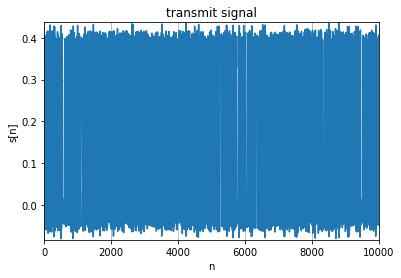

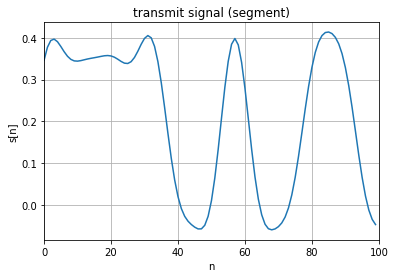

In [24]:
#Plot the time signal in the transmitter in front of the channel. Label the axes and provide a title.
plt.plot(s)
plt.xlim(0, N )
plt.ylim(min(s), max(s))
plt.xlabel('n')
plt.ylabel('s[n]')
plt.title('transmit signal')
plt.grid(True)
plt.show()

plt.plot(s[0:100])
plt.xlim(0, 100 )
plt.ylim(min(s), max(s))
plt.xlabel('n')
plt.ylabel('s[n]')
plt.title('transmit signal (segment)')
plt.grid(True)
plt.show()


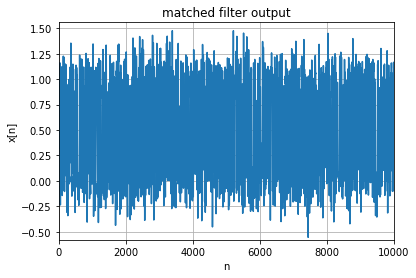

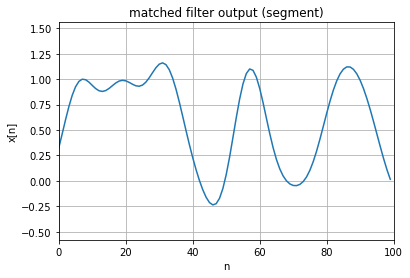

In [25]:
# Plot the time signal after the matched filter but before the downsampler and the decision device.
# Label the axes and provide a title.
plt.plot(x)
plt.xlim(0, N )
plt.ylim(min(x), max(x))
plt.xlabel('n')
plt.ylabel('x[n]')
plt.title('matched filter output')
plt.grid(True)
plt.show()

plt.plot(x[0:100])
plt.xlim(0, 100 )
plt.ylim(min(x), max(x))
plt.xlabel('n')
plt.ylabel('x[n]')
plt.title('matched filter output (segment)')
plt.grid(True)
plt.show()

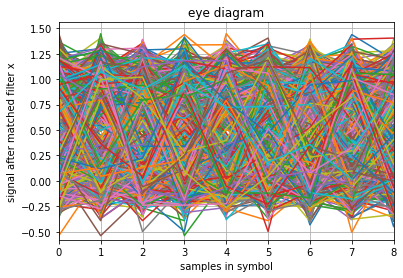

In [26]:
#Plot the eye diagram measured after the matched filter and in front of the downsampler. 
#Label the axes and provide a title.
cnt = round(N/us_factor)

for i in range(cnt):
    plt.plot(x[i * T ::(i+1) * T])
    
plt.xlim(0, T)
plt.ylim(min(x), max(x))
plt.xlabel('samples in symbol')
plt.ylabel('signal after matched filter x')
plt.title('eye diagram')
plt.grid(True)
plt.show()


Text(0, 0.5, 'decision variable z')

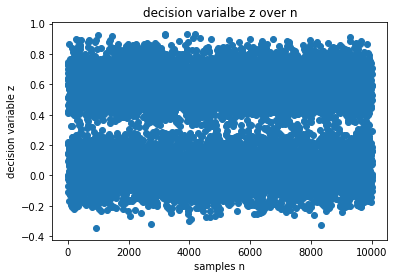

In [27]:
#Plot the scatter diagram in front of the decision device. Label the axes and provide a title.
#insert your code below
plt.scatter(t, z)
plt.title('decision varialbe z over n')
plt.xlabel('samples n')
plt.ylabel('decision variable z')

# Plot BER vs $E_b/N_0$
Run this Notebook seven times for SNR values from 4 to 10 dB in steps of 1 dB with appropriate values for $N$ and note the measured BER.
Now plot the  BER vs values $E_b/N_0$

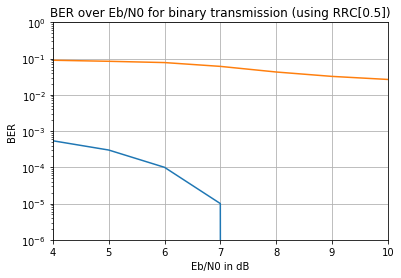

In [45]:
#Insert the values for different SNR in the range from 4 to 10 dB from the sheet or file and plot BER vs Eb/N0
BER_Bi = [0.00054, 0.0003, 0.0001, 0.00001, 0.0, 0.0, 0.0]
BER_Uni = [0.0901, 0.0843, 0.0777, 0.061, 0.0427, 0.0323, 0.0266]
EbN0_Vec = [4, 5, 6, 7, 8, 9, 10]

plt.plot(EbN0_Vec, BER_Bi, label = 'bipolar' )
plt.plot(EbN0_Vec, BER_Uni, label = 'unipolar')
plt.yscale("log")
plt.xlim(4, 10 )
plt.ylim(1/1000000, 1)
plt.xlabel('Eb/N0 in dB')
plt.ylabel('BER')
plt.title('BER over Eb/N0 for binary transmission (using RRC[0.5])')
plt.grid(True)
#plt.legend(color = 'orange', label = 'unipolar')
plt.show()

Compare your results with those from literature. Are there differences? What could be the reason?

**Answer:** One obvious reason is, that in this simulation neither interference nor timing problems are taken into account. So it could be expected, that the results of found here are better than the ones, measured in real systems (or more elaborte simulations). Another point is, that the error resolution for better Eb/N0 is misrepresented, since the size of the choosen bit sequence is too small. However using more appropriate sized bit sequenced, drastically slows down this simulation. Which isn't too surprising, since there was no particular focus on python coding efficiency.